In [9]:
import pandas as pd
import torch
import math
from collections import defaultdict, Counter
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
import os.path
#from fastDamerauLevenshtein import damerauLevenshtein

In [10]:
from fastDamerauLevenshtein import damerauLevenshtein

In [11]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [12]:
import scipy.spatial as sp
from statistics import mean
import numpy as np
from numpy import load
from numpy import save
from collections import defaultdict

In [13]:
###calculate probability of a sentence
def sent_scoring(text):
    input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)  # Batch size 1
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    loss, logits = outputs[:2]
    sentence_prob = math.exp(-loss.item())
    return sentence_prob

In [14]:
#calculate semantic similarity of GPT-2 embeddings
def semDist(str1, str2):    
    text_index1 = tokenizer.encode(str1,add_prefix_space=True)
    text_index2 = tokenizer.encode(str2,add_prefix_space=True)
    vector1 = model.transformer.wte.weight[text_index1,:].detach()
    vector2 = model.transformer.wte.weight[text_index2,:].detach()
    sim = sp.distance.cdist(vector1,vector2,'cosine').diagonal().mean()
    return sim

In [15]:
##calculate phonetic edit distance
def phonDist(str1,str2):
    phondist = damerauLevenshtein(str1, str2, similarity=False, deleteWeight = 1, insertWeight= 1, replaceWeight = 1, swapWeight= 1)
    return phondist

In [16]:
#calculate distortion metric (not weighted by lambda)
def editDistDP(str1,str2,gamma):
    semdist = semDist(str1,str2)
    phondist = phonDist(str1,str2)
    dist = phondist + semdist*gamma
    return dist

In [17]:
def construct_alt():
    alt_lst = []
    for i in range(len(df)):
        alt = list(df[df['item']==df['item'][i]]['sentence'])
        
        alt.insert(0,df['sentence'][i])
        
        res = []
        alt = [res.append(x) for x in alt if x not in res]
   
        alt_lst.append(res)
    df['alt'] = alt_lst 

In [18]:
def prior_storage(filename):
    prior  = []
    for item in list(df['sentence']):
        prior.append(sent_scoring(item))
    df_prior = pd.DataFrame()
    df_prior['sentence'] = df['sentence']
    df_prior['prior'] = prior
    df_prior.to_csv(f'prior_{filename}.csv')
    return df_prior

In [19]:
def distortion_storage(filename):
    phon,sem  = [],[]
    target_lst = []
    alt_tar_lst = []
    for i in range(len(df)):
        target = df['sentence'][i].split()[-1].replace('.','')
        for alt in df['alt'][i]:
            alt_tar = alt.split()[-1].replace('.','')
            phon.append(phonDist(target,alt_tar))
            sem.append(semDist(target,alt_tar))
            target_lst.append(target)
            alt_tar_lst.append(alt_tar)
    
    df_distortion = pd.DataFrame()
    df_distortion['target'] = target_lst
    df_distortion['alt_tar_lst'] = alt_tar_lst
    df_distortion['phon'] = phon
    df_distortion['sem'] = sem
    df_distortion.to_csv(f'distortion_{filename}.csv')
    return df_distortion

In [20]:
def prior_distortion_distribution(idx):
    prior,distortion = [],[]
    target = df['sentence'][idx].split()[-1].replace('.','')
    for item in df['alt'][idx]:
        prior.append(prior_dict[item])
        distortion.append(editDistDP(item.split()[-1].replace('.',''),target,gamma))    
    return np.array(prior),np.array(distortion)

In [21]:
def timecourse(lnp0, d, max_lam=10, num_steps=100):
    """
    Give the predicted processing timecourse given K alternative interpretations for a given input, where
    
    * lnp0 is an array of shape K giving prior log-probabilities for the alternatives.
    * d is an array of shape K giving distortions for each of the K interpretations.
    
    Index 0 is assumed to be the "true" interpretation (lowest distortion).
    """
    #print(lnp0,d)
    lam = np.linspace(0, max_lam, num_steps) # shape L
    unnormalized = lnp0 -lam[:, None]*d[None, :] # shape LK
    lnZ = scipy.special.logsumexp(unnormalized, -1) # shape L
    p = np.exp(unnormalized - lnZ[:, None]) # shape LK
    df = pd.DataFrame(p) # dataframe containing probabilities for each interpretation at each time
    df['t'] = lam
    df['expected_distortion'] = p @ d
    df['variance_distortion'] = p @ d**2 - df['expected_distortion']**2
    df['kl_div'] = -lnZ - lam*df['expected_distortion']
    df['d_kl_div'] = lam * df['variance_distortion']
    return df

In [22]:
###construct new dfs by averaging by conditions
def construct_dfs():
    cond_lst = df['condition'].unique()
    df_dic = defaultdict()
    for cond in cond_lst:
        df_dic[cond] = []

    for i in range(len(df)):
        prior,likeli = prior_distortion_distribution(i)
        trial_df = timecourse(np.log(prior),likeli,max_lam=max_lam, num_steps=num_steps)
        trial_df['condition'] = [df['condition'][i] for j in range(len(trial_df))]
        trial_df['item'] = [df['item'][i] for j in range(len(trial_df))]
        trial_df['eeg'] = -trial_df['d_kl_div']*np.sin(2*np.pi*trial_df['t']/scale)
        df_dic[df['condition'][i]].append(trial_df)

    avgdf_lst = []
    for cond in cond_lst:
        avg_df = pd.concat(df_dic[cond]).groupby('t').mean().reset_index()
        avg_df['condition'] = [cond for i in range(len(avg_df))]
        avgdf_lst.append(avg_df)
    df_all = pd.concat(avgdf_lst)
    return df_all

In [35]:
def plot_timecourse(df,cond_name):
    cond_lst = df['condition'].unique()
    fig, axs = plt.subplots(3,3, figsize=(10, 10))

    # plot kl divergences
    axs[0,0].set_title("Cumulative Effort")
    axs[0,0].set_ylabel("KL Divergence, D(t)")
    axs[0,0].set_xlabel("Time t (ms)")
    axs[0,0].set_xlim(0,T/2)
    for cond in cond_lst:
        axs[0,0].plot(t, df[df['condition'] == cond]['kl_div'], label=cond)
    axs[0,0].legend()

    axs[0,1].set_title("Instantaneous Effort")
    axs[0,1].set_xlabel("Time t (ms)")
    axs[0,1].set_ylabel("KL Divergence Rate, d/dt D(t)")
    axs[0,1].set_xlim(0,T/2)
    for cond in cond_lst:
        axs[0,1].plot(t, df[df['condition'] == cond]['d_kl_div'], label=cond)
    axs[0,1].legend()
    

    axs[0,2].set_title("EEG Simulation")
    axs[0,2].set_ylabel("Voltage")
    axs[0,2].set_xlabel("Time t (ms)")
    axs[0,2].set_xlim(0,T/2)
    for cond in cond_lst:
        axs[0,2].plot(t, df[df['condition'] == cond]['eeg'], label=cond)
    axs[0,2].legend()   
    
    for i in range(len(cond_name)-1):
        axs[1,i].set_title(f"{cond_name[i+1]} Scenario")
        axs[1,i].set_xlabel("Time t (ms)")
        axs[1,i].set_ylabel("Probability")
        axs[1,i].set_xlim(0, T/2)

        axs[1,i].plot(t, df[df['condition'] == cond_name[i+1]][0], label="Target")
        axs[1,i].plot(t, df[df['condition'] == cond_name[i+1]][1], label="Distractor")
        axs[1,i].plot(t, df[df['condition'] == cond_name[i+1]][2], label="Far Distractor")
        axs[1,i].legend()


    df['region'] = df['t'].map(lambda t: 'P600' if (t/max_lam)>(cutoff/T) else 'N400')
    r = df[['region', 'condition', 'eeg']].groupby(['region', 'condition']).sum().reset_index()
    categories = ["N400", "P600"]
    
    for i in range(len(cond_name)-1):

        axs[2,i].set_ylabel("Sum Voltage")
        axs[2,i].set_xlabel("Time Window")
        axs[2,i].bar(categories, np.array(r[r['condition'] == cond_name[i+1]]['eeg']) - np.array(r[r['condition'] == cond_name[0]]['eeg']))
        #axs[2,0].set_ylim(-30,10)

    plt.tight_layout(pad=2.0)


   

In [24]:
###define some global parameters
scale=1
max_lam = 15
num_steps = 1000
T = 3
t = np.linspace(0, max_lam, num_steps)
cutoff=0.12

In [25]:
def main(filename):
    df = pd.read_csv(f'{filename}_stimuli.csv')
    construct_alt()
    if os.path.isfile(f'prior_{filename}.csv'):
        df_prior = pd.read_csv(f'prior_{filename}.csv')
    else:
        df_prior = prior_storage(filename)
    prior_dict = df_prior[['sentence','prior']].set_index('sentence').T.to_dict('records')[0]

    if os.path.isfile(f'distortion_{filename}.csv'):
        df_distortion = pd.read_csv(f'distortion_{filename}.csv')
    else:
        df_distortion = distortion_storage(filename)  
    df_plot = construct_dfs()
    plot_timecourse(df_plot)
    return df_plot


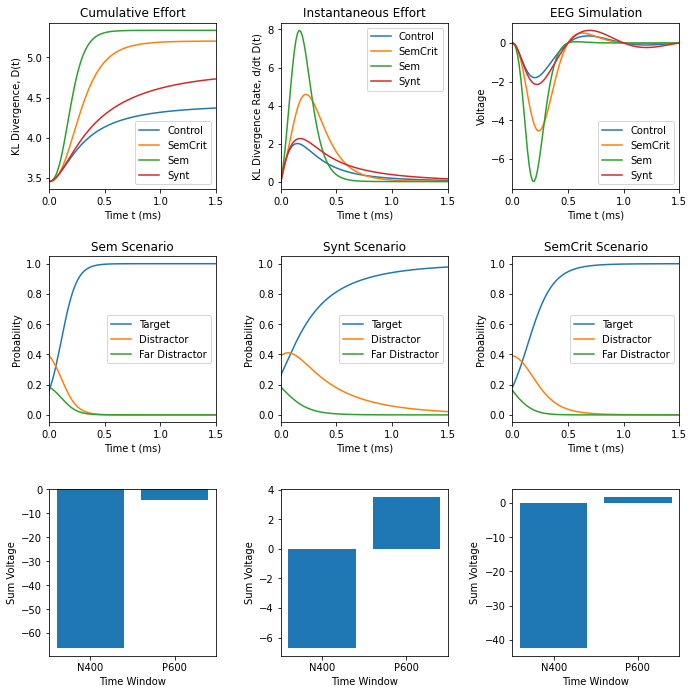

In [36]:
###define some global parameters
scale=1
max_lam = 15
num_steps = 1000
T = 3
t = np.linspace(0, max_lam, num_steps)
cutoff=0.12
gamma=10
filename='ryskin'
cond_name = ['Control','Sem','Synt','SemCrit']

df = pd.read_csv(f'stimuli/{filename}_stimuli.csv')
construct_alt()
if os.path.isfile(f'storage/prior_{filename}.csv'):
    df_prior = pd.read_csv(f'storage/prior_{filename}.csv')
else:
    df_prior = prior_storage(filename)
prior_dict = df_prior[['sentence','prior']].set_index('sentence').T.to_dict('records')[0]

if os.path.isfile(f'storage/distortion_{filename}.csv'):
    df_distortion = pd.read_csv(f'storage/distortion_{filename}.csv')
else:
    df_distortion = distortion_storage(filename)  
df_plot = construct_dfs()
plot_timecourse(df_plot,cond_name)

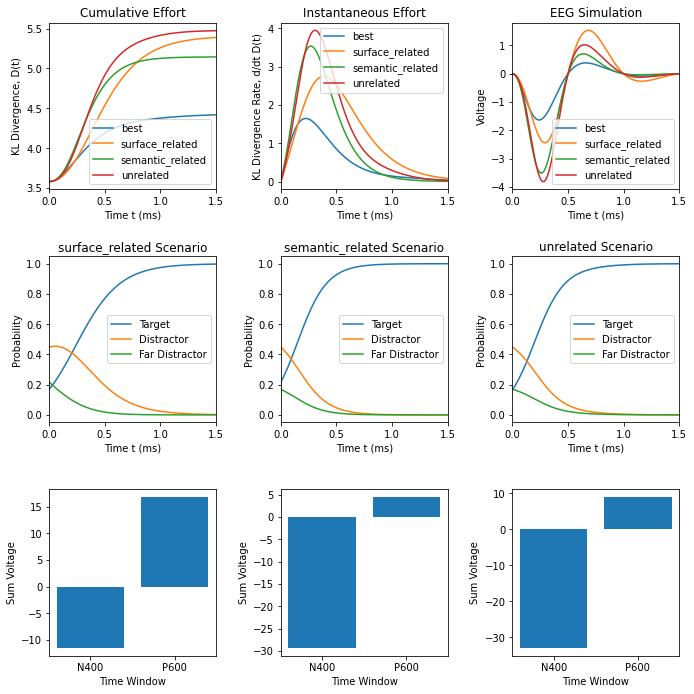

In [37]:
###define some global parameters
scale=1
max_lam = 15
num_steps = 1000
T = 3
t = np.linspace(0, max_lam, num_steps)
cutoff=0.12
gamma = 5
filename='priming'
first_time = False
cond_name = ['best','surface_related','semantic_related','unrelated']

df = pd.read_csv(f'stimuli/{filename}_stimuli.csv')
construct_alt()
if os.path.isfile(f'storage/prior_{filename}.csv'):
    df_prior = pd.read_csv(f'storage/prior_{filename}.csv')
else:
    df_prior = prior_storage(filename)
prior_dict = df_prior[['sentence','prior']].set_index('sentence').T.to_dict('records')[0]

if os.path.isfile(f'storage/distortion_{filename}.csv'):
    df_distortion = pd.read_csv(f'storage/distortion_{filename}.csv')
else:
    df_distortion = distortion_storage(filename)  
df_plot = construct_dfs()
plot_timecourse(df_plot,cond_name)